In [20]:
from graph_utils import generate_graph, graph_to_jraph as graph_to_jraph
import networkx as nx
import matplotlib.pyplot as plt
import jraph

In [21]:
n_graphs = 100
n_nodes = 100

nx_graphs = [
    generate_graph(n_nodes, prob=0.05, graph_type="erdos", random_seed=i)
    # generate_graph(n_nodes, degree=3, graph_type="reg", random_seed=i)
    for i in range(0, n_graphs)
]
jraph_graphs = [graph_to_jraph(nx_graph, pos) for nx_graph, pos in nx_graphs]

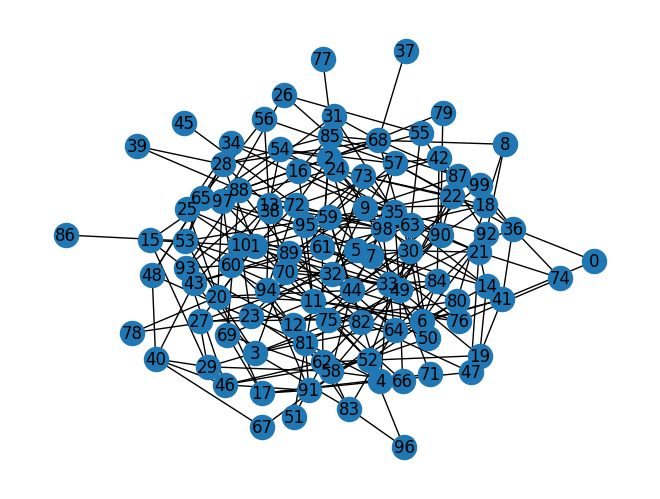

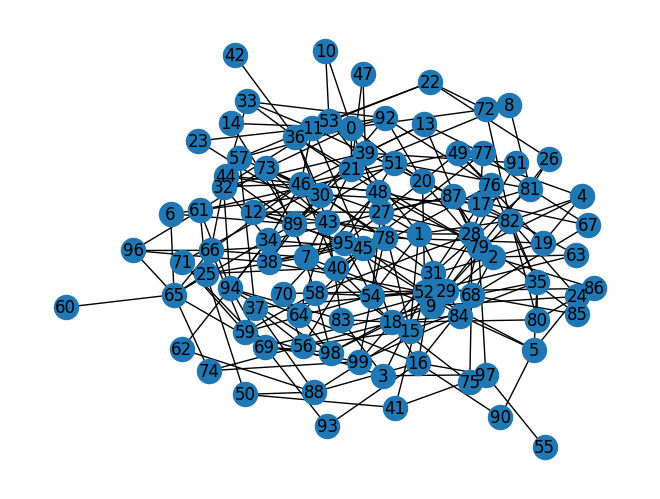

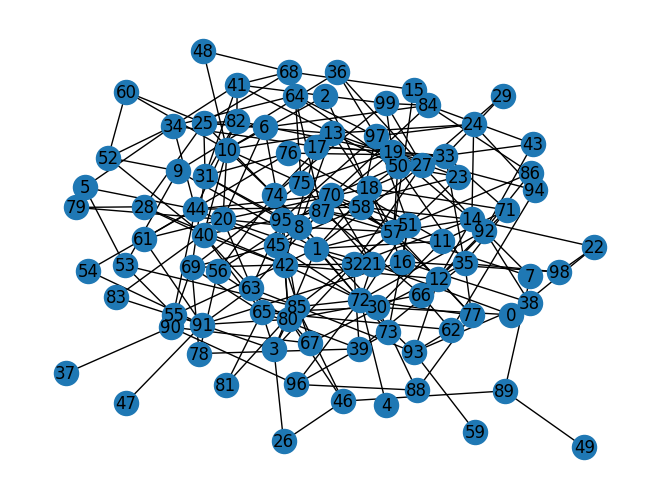

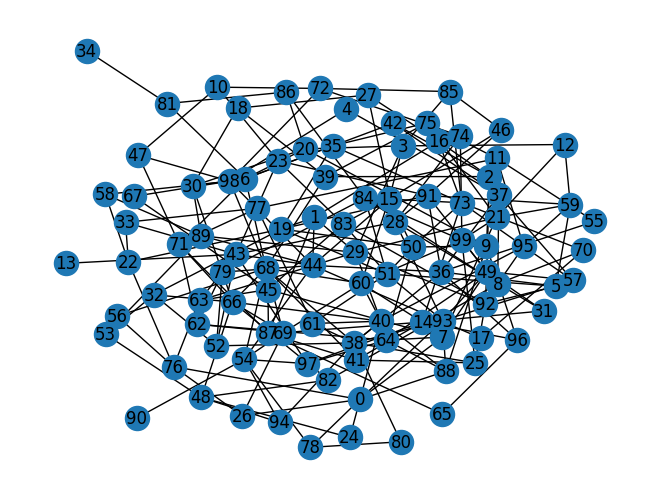

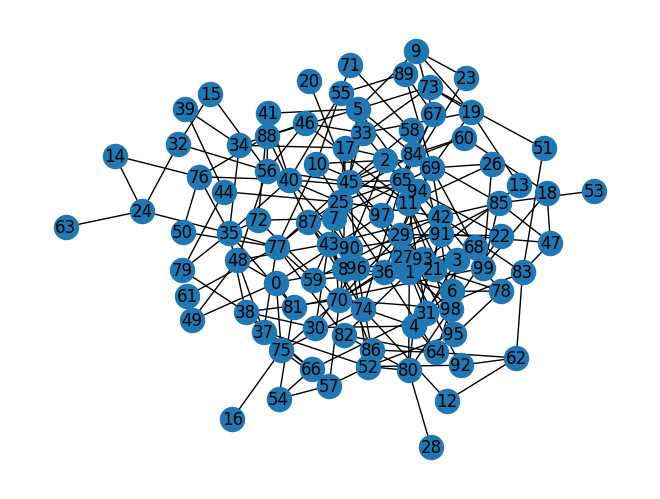

In [22]:
def draw_graphs(nx_graphs: list[nx.Graph]):
    for (nx_graph, pos), _ in zip(nx_graphs, range(5)):
        nx.draw(nx_graph, pos=pos, with_labels=True)
        plt.show()


draw_graphs(nx_graphs)

In [23]:
batched = jraph.batch(jraph_graphs)

In [24]:
batched

GraphsTuple(nodes=Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), edges=Array([0.34336668, 0.3918295 , 0.39386338, ..., 0.3858799 , 0.27344525,
       0.40072474], dtype=float32), receivers=Array([  36,   41,   15, ..., 9984, 9987, 9992], dtype=int32), senders=Array([   0,    0,    1, ..., 9999, 9995, 9995], dtype=int32), globals=None, n_node=Array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 10

In [25]:
from gcn import GCN
import flax.linen as nn
import optax

In [26]:
from jraph import GraphsTuple
from vertex_cover import train_step, TrainState, Array
import jax
import jax.numpy as np
from jax import jit, value_and_grad
from tqdm.auto import tqdm
from flax.typing import PRNGKey, FrozenDict, Any, Callable
from functools import partial


def vertex_cover_loss(graph: jraph.GraphsTuple) -> Callable[[Array], Array]:

    senders = graph.senders
    receivers = graph.receivers

    def loss_function(probs: Array) -> Array:
        neg_probs = 1.0 - probs
        # H_A = np.sum(neg_probs[senders] * neg_probs[receivers])
        H_A = np.dot(neg_probs[senders].T, neg_probs[receivers]).sum()
        # Q = neg_probs @ neg_probs.T

        # H_A = np.sum(Q[senders, receivers])
        H_B = np.sum(probs)

        return H_A + H_B

    return loss_function


@jit
def train_step(
    state: TrainState, graph: jraph.GraphsTuple, dropout_key: PRNGKey
) -> tuple[TrainState, Array, Array]:
    """Perform a single training step.

    Args:
        state (TrainState): The training state.
        graph (jraph.GraphsTuple): The graph to train on.

    Returns:
        TrainState: The updated training state.
    """
    loss_function = vertex_cover_loss(graph)
    dropout_train_key = jax.random.fold_in(key=dropout_key, data=state.step)

    def loss_fn(params: FrozenDict[str, Any]) -> tuple[Array, Array]:
        predictions = state.apply_fn(
            params,
            graph,
            training=True,
            rngs={"dropout": dropout_train_key},
        )

        predictions: jraph.GraphsTuple
        predictions = predictions.nodes.flatten()
        loss = loss_function(predictions)
        return loss, predictions

    (loss, probs), grads = value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)

    return state, loss, probs


def train(
    graphs: jraph.GraphsTuple,
    net: GCN,
    optimizer: optax.GradientTransformation,
    num_epochs: int = 100,
    random_seed: int = 0,
    tol: float = 0.01,
    patience: int = 100,
) -> tuple[TrainState, Array]:
    graph = graphs

    max_nodes = np.max(graph.n_node)
    max_edges = np.max(graph.n_edge)
    num_graphs = graph.n_node.shape[0]
    batch_size = 1
    num_batches = num_graphs // batch_size

    graph_list = jraph.unbatch(graphs)

    main_key = jax.random.PRNGKey(random_seed)
    main_key, init_rng, dropout_key = jax.random.split(main_key, num=3)

    batches = []
    for i in range(num_batches):
        # batch = jraph.batch(graph_list[i * batch_size : (i + 1) * batch_size])
        batch = jraph.batch(
            [graph_list[i]
                for i in range(i * batch_size, (i + 1) * batch_size)]
        )
        padded_batch = jraph.pad_with_graphs(
            batch,
            n_node=batch_size * max_nodes + 1,
            n_edge=batch_size * max_edges,
            n_graph=batch_size + 1,
        )
        batches.append(padded_batch)

    params = net.init(
        init_rng,
        batches[0],
        training=True,
    )
    state = TrainState.create(
        apply_fn=net.apply,
        params=params,
        key=dropout_key,
        tx=optimizer,
    )

    @jit
    def eval_fn(probs: Array, graph: jraph.GraphsTuple) -> Array:
        eval_probs = (probs > 0.5) * 1.0
        eval_loss = vertex_cover_loss(graph)(eval_probs)
        # print(np.sum(eval_probs), eval_loss)
        # print(probs.shape)
        return eval_loss

    count = 0
    best_loss = np.inf
    pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")

    losses = []
    evals = []

    for epoch in pbar:
        epoch_loss = 0.0
        epoch_eval = 0.0

        state, epoch_loss, probs = train_step(state, graph, dropout_key)

        epoch_eval = eval_fn(probs, graph)

        # for batch in batches:
        #     state, batch_loss, probs = train_step(state, batch, dropout_key)

        #     eval_loss = eval_fn(probs, batch)

        #     epoch_loss += batch_loss
        #     epoch_eval += eval_loss

        epoch_loss /= num_graphs
        epoch_eval /= num_graphs
        losses.append(epoch_loss)
        evals.append(epoch_eval)

        pbar.set_postfix(
            {
                "loss": f"{epoch_loss:.4f}",
                "eval": f"{epoch_eval:.4f}",
                "diff": f"{best_loss - epoch_loss:.4f}",
                "patience": f"{count / patience * 100:.1f}%",
            }
        )

        if best_loss - epoch_loss > tol or np.isinf(best_loss):
            if epoch_loss < best_loss:
                best_loss = epoch_loss
            count = 0
        else:
            count += 1
            if count > patience:
                print(f"Early stopping at epoch {epoch}")
                pbar.close()
                break

    print(probs)
    return state, losses, evals

In [42]:
hidden_size = 100
n_class = 1
num_layers = 1
num_convolutions = 2
dropout_rate = 0.0

n_epochs = 10000
lr = 0.001

optimizer = optax.adam(learning_rate=lr)
# optimizer = optax.sgd(learning_rate=lr)
net = GCN(
    hidden_size,
    n_class,
    # activation=nn.relu,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    output_activation=nn.sigmoid,
    num_convolutions=num_convolutions,
)

state, losses, evals = train(
    batched,
    net,
    optimizer,
    n_epochs,
    tol=0.01,
    patience=1000,
)

Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

[8.3325511e-05 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00 1.2008101e-05
 1.0000000e+00]


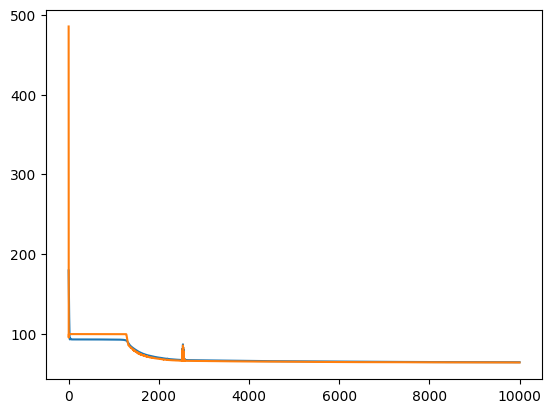

In [43]:
start = 0

plt.plot(losses[start:])
# plt.plot(sizes)
# plt.ylim(30, 50)
# plt.ylim(min(losses) * 0.9, losses[0] * 1.1)
plt.plot(evals[start:])

In [44]:
validation_graph = jraph_graphs[0]

predictions = state.apply_fn(state.params, validation_graph, training=False)

In [45]:
pred_prob = predictions.nodes

In [46]:
pred_prob = (pred_prob > 0.5) * 1.0

In [47]:
def evaluate_prob(
    pred_prob: Array,
    nx_graph: nx.Graph,
    pos: dict[int, tuple[float, float]],
    draw: bool = True,
) -> None:
    if draw:
        colors = []
        for p in pred_prob:
            color = "orange" if p else "lightblue"
            colors.append(color)

        nx.draw(nx_graph, pos=pos, node_color=colors)

    violations = 0
    unneccesary = 0

    for i, j in nx_graph.edges:
        violations += ((1 - pred_prob[i]) * (1 - pred_prob[j])).sum()

    for u in nx_graph.nodes:
        if not pred_prob[u]:
            continue
        for v in nx_graph.neighbors(u):
            if not pred_prob[v]:
                break
        else:
            unneccesary += 1

    print(f"Violations: {violations}")
    print(f"Size of cover: {np.sum(pred_prob)}")
    print(f"Unneccesary nodes: {unneccesary}")

    return violations, np.sum(pred_prob), unneccesary

Violations: 0.0
Size of cover: 64.0
Unneccesary nodes: 2


(Array(0., dtype=float32), Array(64., dtype=float32), 2)

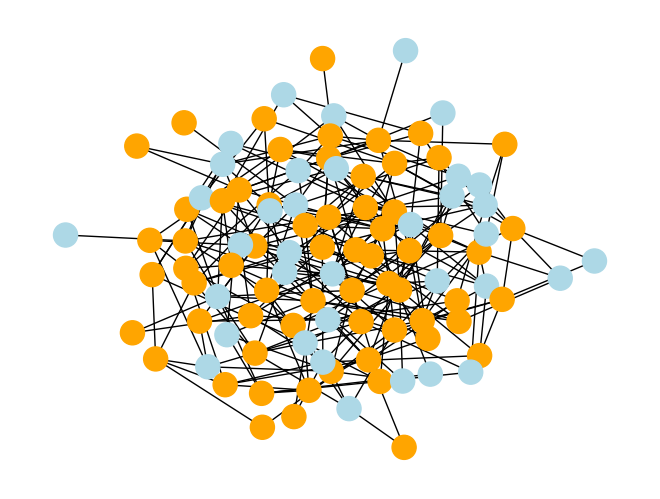

In [48]:
nx_graph, pos = nx_graphs[0]
evaluate_prob(pred_prob, nx_graph, pos)

In [56]:
import numpy as onp
from networkx.algorithms.approximation import min_weighted_vertex_cover

results_test = onp.zeros((n_graphs, 3))
approx_test = onp.zeros((n_graphs, 1))

for i, (jraph_graph, (nx_graph, pos)) in enumerate(zip(jraph_graphs, nx_graphs)):
    predictions = state.apply_fn(state.params, jraph_graph, training=False)
    pred_prob = predictions.nodes
    pred_prob = (pred_prob > 0.5) * 1.0
    res = evaluate_prob(pred_prob, nx_graph, pos, draw=False)

    res = onp.array(res)
    results_test[i, :] = res

    approx_res = len(min_weighted_vertex_cover(nx_graph))
    approx_test[i] = approx_res

Violations: 0.0
Size of cover: 64.0
Unneccesary nodes: 2
Violations: 0.0
Size of cover: 62.0
Unneccesary nodes: 5
Violations: 2.0
Size of cover: 62.0
Unneccesary nodes: 0
Violations: 0.0
Size of cover: 59.0
Unneccesary nodes: 3
Violations: 0.0
Size of cover: 63.0
Unneccesary nodes: 7
Violations: 1.0
Size of cover: 67.0
Unneccesary nodes: 11
Violations: 0.0
Size of cover: 69.0
Unneccesary nodes: 10
Violations: 0.0
Size of cover: 67.0
Unneccesary nodes: 4
Violations: 1.0
Size of cover: 63.0
Unneccesary nodes: 6
Violations: 1.0
Size of cover: 67.0
Unneccesary nodes: 5
Violations: 3.0
Size of cover: 57.0
Unneccesary nodes: 0
Violations: 0.0
Size of cover: 68.0
Unneccesary nodes: 11
Violations: 0.0
Size of cover: 63.0
Unneccesary nodes: 3
Violations: 0.0
Size of cover: 61.0
Unneccesary nodes: 6
Violations: 0.0
Size of cover: 65.0
Unneccesary nodes: 5
Violations: 0.0
Size of cover: 60.0
Unneccesary nodes: 6
Violations: 0.0
Size of cover: 60.0
Unneccesary nodes: 2
Violations: 0.0
Size of cove

In [57]:
onp.sum(results_test, axis=0)

array([  42., 6290.,  436.])

In [58]:
onp.sum(approx_test)

7854.0

In [59]:
nx_validations = [
    generate_graph(n_nodes, prob=0.05, graph_type="erdos", random_seed=i)
    # generate_graph(n_nodes, degree=3, graph_type="reg", random_seed=i)
    for i in range(2024, 2024 + n_graphs)
]
jraph_validations = [graph_to_jraph(nx_graph, pos) for nx_graph, pos in nx_validations]

Violations: 4.0
Size of cover: 78.0
Unneccesary nodes: 40
Violations: 1.0
Size of cover: 89.0
Unneccesary nodes: 59
Violations: 17.0
Size of cover: 58.0
Unneccesary nodes: 15
Violations: 23.0
Size of cover: 58.0
Unneccesary nodes: 13
Violations: 4.0
Size of cover: 79.0
Unneccesary nodes: 32
Violations: 40.0
Size of cover: 58.0
Unneccesary nodes: 15
Violations: 12.0
Size of cover: 70.0
Unneccesary nodes: 29
Violations: 22.0
Size of cover: 65.0
Unneccesary nodes: 25
Violations: 0.0
Size of cover: 91.0
Unneccesary nodes: 77
Violations: 27.0
Size of cover: 66.0
Unneccesary nodes: 28
Violations: 24.0
Size of cover: 67.0
Unneccesary nodes: 25
Violations: 7.0
Size of cover: 75.0
Unneccesary nodes: 36
Violations: 2.0
Size of cover: 79.0
Unneccesary nodes: 42
Violations: 29.0
Size of cover: 62.0
Unneccesary nodes: 17
Violations: 0.0
Size of cover: 86.0
Unneccesary nodes: 58
Violations: 40.0
Size of cover: 64.0
Unneccesary nodes: 23
Violations: 25.0
Size of cover: 56.0
Unneccesary nodes: 10
Viol

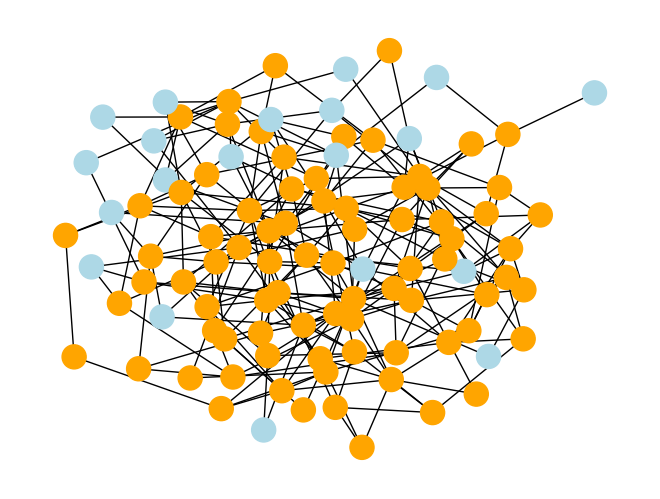

In [60]:
import numpy as onp
from networkx.algorithms.approximation import min_weighted_vertex_cover

results_val = onp.zeros((n_graphs, 3))
approx_val = onp.zeros((n_graphs, 1))

for i, (jraph_graph, (nx_graph, pos)) in enumerate(
    zip(jraph_validations, nx_validations)
):
    predictions = state.apply_fn(state.params, jraph_graph, training=False)
    pred_prob = predictions.nodes
    pred_prob = (pred_prob > 0.5) * 1.0
    res = evaluate_prob(pred_prob, nx_graph, pos, draw=False)

    res = onp.array(res)
    results_val[i, :] = res

    approx_res = len(min_weighted_vertex_cover(nx_graph))
    approx_val[i] = approx_res

predictions = state.apply_fn(state.params, jraph_graph, training=False)
pred_prob = predictions.nodes
pred_prob = (pred_prob > 0.5) * 1.0
res = evaluate_prob(pred_prob, nx_graph, pos, draw=True)

In [77]:
import pandas as pd

columns = ["violated edges", "size of cover", "unneccesary nodes", "approximation"]

df_test = pd.DataFrame(results_test, columns=columns[:-1])
df_test[columns[-1]] = approx_test

df_val = pd.DataFrame(results_val, columns=columns[:-1])
df_val[columns[-1]] = approx_val

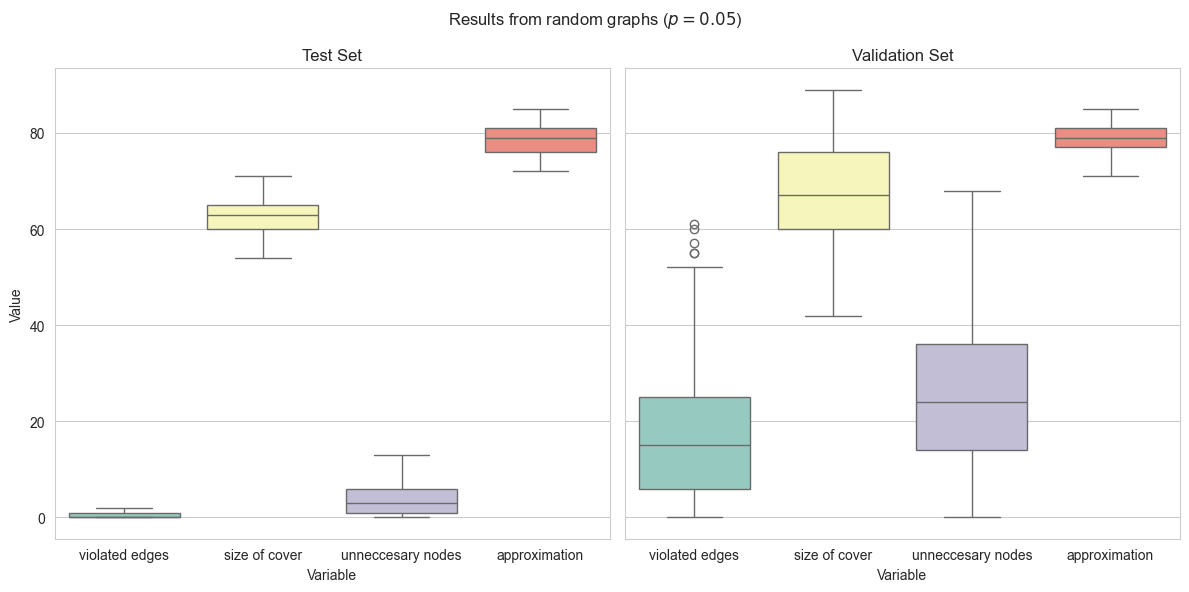

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt


def clean(df: pd.DataFrame) -> pd.DataFrame:
    # Calculate the IQR for each column
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # Define the upper and lower bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers from the DataFrame
    df_no_outliers = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]
    return df_no_outliers


def boxplot_on_ax(df: pd.DataFrame, ax: plt.Axes, title: str) -> None:
    sns.boxplot(data=clean(df), ax=ax, palette="Set3")
    ax.set_title(title)
    ax.set_xlabel("Variable")
    ax.set_ylabel("Value")


sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot the test set results
boxplot_on_ax(df_test, axes[0], "Test Set")
boxplot_on_ax(df_val, axes[1], "Validation Set")

fig.suptitle("Results from random graphs ($p=0.05$)")
plt.tight_layout()
plt.show()